# BCG - PowerCo customer churn problem : Forage Project

## Background
This challenge is about predicting the cutomers churn of one of BCG's clients called PowerCo. PowerCo is a leader specializing in gas and electricity distribution to residential neighburhoods and SMEs. Due to liberalization policies in the power sector, many companies are being forced to reduce their long-run average costs in order to remain competitive in the market. They want a new,viable and effective pricing stategy to combat customer churn. PowerCo wants to explore the possibility of a 20% discounted rate preventing customer churn and have commissioned BCG to test this hypothesis. 

## TASK 1: Business Understanding & Hypothesis Framing
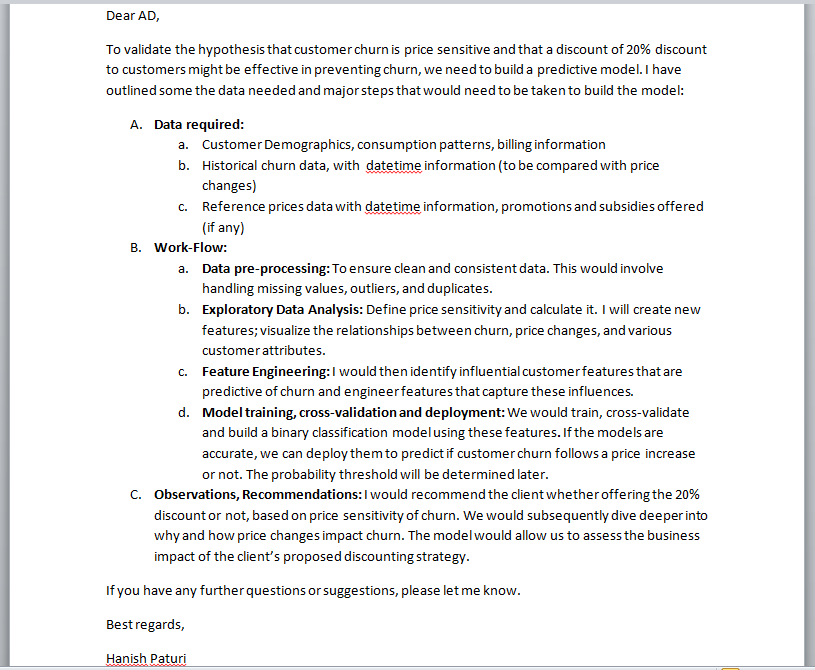

## TASK 2: Exploratory Data Analysis

We have been given the following sub-tasks to carry-out.

### Sub-Task 1:

Perform some exploratory data analysis. Look into the data types, data statistics, specific parameters, and variable distributions. This first subtask is for you to gain a holistic understanding of the dataset. You should spend around 1 hour on this.

### Sub-Task 2:

Verify the hypothesis of price sensitivity being to some extent correlated with churn. It is up to you to define price sensitivity and calculate it. You should spend around 30 minutes on this.


### Sub-Task 3:

Prepare a half-page summary or slide of key findings and add some suggestions for data augmentation – which other sources of data should the client provide you with and which open source datasets might be useful? You should spend 10-15 minutes on this.

For your final deliverable, please submit your analysis (in the form of a jupyter notebook, code script or PDF) as well as your half-page summary document.

**Note:** Use the 2 datasets within the additional resources for this task and if you’re unsure on where to start with visualizing data, use the accompanying links. Be sure to also use the data description document to understand what the columns represent. The task description document outlines the higher-level motivation of the project. Finally, use the eda_starter.ipynb file to get started with some helper functions and methods.

If you are stuck: Think about ways you can define price sensitivity. Make sure to think of all possible ways and investigate them.

Estimated time for task completion: 1.75 hours depending on your learning style.

## TASK 2 Outline: EDA

### Sub-task 1: 
1. Exploratory Data Analysis, to look for important features, trends and patterns, and to to analyze missing values, outliers, etc
2. Check and identify whether the churn happened  with a price increase 3 months prior.

### Sub-task 2:
1. We will define price sensitivity of churn at a given reference price as the % of customers churned within 3 months of a positive change in prices. Soft churn (if present) will be considered as hard churn. We will look into other definitions of price sensiivity at a later stage after exploring the raw data.

2. We will test the null hypothesis that customer churn is sensitive to price increase. The alternate hypohesis being that customer churn is insensitive to price increae. We will check this for a 95% confidence interval (of all churn observations).


### Sub-task 3:
Report write-up with summary findings and suggestions for data augmentation.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.stats import skew

import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from IPython.display import display

%matplotlib inline
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.float_format', lambda x: '%.3f' % x)
# Shows plots in jupyter notebook
%matplotlib inline


# Set plot style
sns.set(color_codes=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading data with Pandas

We need to load `client_data.csv` and `price_data.csv` into individual dataframes so that we can work with them in Python. For this notebook and all further notebooks, it will be assumed that the CSV files will the placed in the same file location as the notebook. If they are not, please adjust the directory within the `read_csv` method accordingly.

In [2]:
client = pd.read_csv('/kaggle/input/bcg-intership-files/client_data.csv')
price = pd.read_csv('/kaggle/input/bcg-intership-files/price_data.csv')

client_data.csv

●	id = client company identifier

●	activity_new = category of the company’s activity

●	channel_sales = code of the sales channel

●	cons_12m = electricity consumption of the past 12 months

●	cons_gas_12m = gas consumption of the past 12 months

●	cons_last_month = electricity consumption of the last month

●	date_activ = date of activation of the contract

●	date_end = registered date of the end of the contract

●	date_modif_prod = date of the last modification of the product

●	date_renewal = date of the next contract renewal

●	forecast_cons_12m = forecasted electricity consumption for next 12 months

●	forecast_cons_year = forecasted electricity consumption for the next calendar year

●	forecast_discount_energy = forecasted value of current discount

●	forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months

●	forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak)

●	forecast_price_energy_peak = forecasted energy price for 2nd period (peak)

●	forecast_price_pow_off_peak = forecasted power price for 1st period (off peak)

●	has_gas = indicated if client is also a gas client

●	imp_cons = current paid consumption

●	margin_gross_pow_ele = gross margin on power subscription

●	margin_net_pow_ele = net margin on power subscription

●	nb_prod_act = number of active products and services

●	net_margin = total net margin

●	num_years_antig = antiquity of the client (in number of years)

●	origin_up = code of the electricity campaign the customer first subscribed to

●	pow_max = subscribed power

●	churn = has the client churned over the next 3 months


Note: some fields are hashed text strings. This preserves the privacy of the original data but the commercial meaning is retained and so they may have predictive power


price_data.csv

●	id = client company identifier

●	price_date = reference date

●	price_off_peak_var = price of energy for the 1st period (off peak)

●	price_peak_var = price of energy for the 2nd period (peak)

●	price_mid_peak_var = price of energy for the 3rd period (mid peak)

●	price_off_peak_fix = price of power for the 1st period (off peak)

●	price_peak_fix = price of power for the 2nd period (peak)

●	price_mid_peak_fix = price of power for the 3rd period (mid peak)

# Sub-task 1: EDA


In [3]:
client.info(), price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

(None, None)

In [4]:
'''for i in client.columns:    
    print(client.loc[j,i] for j in range(len(client)) if client.loc[j,i]=='MISSING')'''

"for i in client.columns:    \n    print(client.loc[j,i] for j in range(len(client)) if client.loc[j,i]=='MISSING')"

In [5]:
'''for i in client.columns:
    for j in range(len(client)): 
        if client.loc[j,i]== 'MISSING':
            print(client.loc[j,i])'''

"for i in client.columns:\n    for j in range(len(client)): \n        if client.loc[j,i]== 'MISSING':\n            print(client.loc[j,i])"

There seems to be no null values. Let's explore further.

In [6]:
client.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.000,0,0.000,1.780,0.114,0.098,40.607,t,0.000,25.440,25.440,2,678.990,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.950,0,0.000,16.270,0.146,0.000,44.311,f,0.000,16.380,16.380,1,18.890,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.960,0,0.000,38.720,0.166,0.088,44.311,f,0.000,28.600,28.600,1,6.600,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.040,0,0.000,19.830,0.147,0.000,44.311,f,0.000,30.220,30.220,1,25.460,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.750,526,0.000,131.730,0.117,0.100,40.607,f,52.320,44.910,44.910,1,47.980,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [7]:
price.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151,0.000,0.000,44.267,0.000,0.000
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151,0.000,0.000,44.267,0.000,0.000
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151,0.000,0.000,44.267,0.000,0.000
3,038af19179925da21a25619c5a24b745,2015-04-01,0.150,0.000,0.000,44.267,0.000,0.000
4,038af19179925da21a25619c5a24b745,2015-05-01,0.150,0.000,0.000,44.267,0.000,0.000


In [8]:
client.isna().sum(), price.isna().sum()

(id                                0
 channel_sales                     0
 cons_12m                          0
 cons_gas_12m                      0
 cons_last_month                   0
 date_activ                        0
 date_end                          0
 date_modif_prod                   0
 date_renewal                      0
 forecast_cons_12m                 0
 forecast_cons_year                0
 forecast_discount_energy          0
 forecast_meter_rent_12m           0
 forecast_price_energy_off_peak    0
 forecast_price_energy_peak        0
 forecast_price_pow_off_peak       0
 has_gas                           0
 imp_cons                          0
 margin_gross_pow_ele              0
 margin_net_pow_ele                0
 nb_prod_act                       0
 net_margin                        0
 num_years_antig                   0
 origin_up                         0
 pow_max                           0
 churn                             0
 dtype: int64,
 id                    

Lets first convert the object features with date data to datetime type.

In [9]:
## Lets first convert the object features with date data to datetime type
date_features =['date_activ','date_end','date_modif_prod', 'date_renewal']
for feature in date_features:
    client[feature] = pd.to_datetime(client[feature])
price['price_date'] = pd.to_datetime(price['price_date'])
    
print(client[date_features].dtypes)

## Lets add three new columns
client['contract_start_year'] = client['date_activ'].dt.year
client['contract_end_year'] = client['date_end'].dt.year
client['period_subscribed'] = client['contract_end_year']-client['contract_start_year']

date_activ         datetime64[ns]
date_end           datetime64[ns]
date_modif_prod    datetime64[ns]
date_renewal       datetime64[ns]
dtype: object


In [10]:
price['price_date'].dtypes

dtype('<M8[ns]')

Now let's define a function to explore categorical features

In [11]:
def descr_cat_features(dataset):
    cat_columns = dataset.dtypes[dataset.dtypes=='O'].index.tolist()
    if len(cat_columns)!=0:
        print('Categorical variables are', cat_columns,'\n'+'=='*40)
        for cat in cat_columns:
            describe_frame = dataset[[cat]].value_counts().reset_index(name='count')
            describe_frame['proportion'] = describe_frame['count']/len(dataset)
            print(describe_frame,'\n'+'--'*40)    # display value count and proportion of a categorical feature
    else:
        print('There is no categorical variables in the dataset')
        
# dataset: a pandas dataframe;
def descr_num_features(dataset):
    # for numeric columns whose values are discrete, display values and their frequency
    int_columns = dataset.dtypes[dataset.dtypes=='int'].index.tolist()
    # for numeric columns whose values are continuous, plot their value distribution
    float_columns = dataset.dtypes[dataset.dtypes=='float'].index.tolist()
    if len(int_columns)+len(float_columns)!=0:
        print('Numeric variables are', int_columns+float_columns,'\n'+'=='*40)
        # integer numeric feature
        if len(int_columns)!=0:    
            for cat in int_columns:
                describe_frame = dataset[[cat]].value_counts().reset_index(name='count')
                describe_frame['proportion'] = describe_frame['count']/len(dataset)
                print(describe_frame,'\n'+'--'*40)    # display value count and proportion of a categorical feature
        # 
        print(dataset[int_columns + float_columns].describe().loc[['min','max','mean','50%']].T.rename(columns={'50%':'median'}), '\n'+'--'*40)
    else:
        print('There is no numeric variables in the dataset')

In [12]:
descr_cat_features(client)

Categorical variables are ['id', 'channel_sales', 'has_gas', 'origin_up'] 
                                     id  count  proportion
0      0002203ffbb812588b632b9e628cc38d      1       0.000
1      ab250252dfaded1c9a54834f9c829b43      1       0.000
2      ab32c3a8d93c88b485499566526cb34d      1       0.000
3      ab3392ec2bfd3605624f31d3c6828c21      1       0.000
4      ab346731fef5aa291919ea43e45af5a7      1       0.000
...                                 ...    ...         ...
14601  55091aace7bd0fadd194f46cb4886fea      1       0.000
14602  550b8d2f9c298abd8f05fca3bc1a13c4      1       0.000
14603  5514b18508f378a39f41657554aa72e3      1       0.000
14604  551cb1b1faf72259c2c182dedec12c98      1       0.000
14605  ffff7fa066f1fb305ae285bb03bf325a      1       0.000

[14606 rows x 3 columns] 
--------------------------------------------------------------------------------
                      channel_sales  count  proportion
0  foosdfpfkusacimwkcsosbicdxkicaua   6754       0.462

In [13]:
descr_num_features(client)

Numeric variables are ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_year', 'nb_prod_act', 'num_years_antig', 'churn', 'contract_start_year', 'contract_end_year', 'period_subscribed', 'forecast_cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max'] 
       cons_12m  count  proportion
0             0    117       0.008
1       2882597     27       0.002
2       3329244     24       0.002
3       1743025     18       0.001
4       3926060     18       0.001
...         ...    ...         ...
11060     10297      1       0.000
11061     10305      1       0.000
11062     10311      1       0.000
11063     10312      1       0.000
11064     14285      1       0.000

[11065 rows x 3 columns] 
--------------------------------------------------------------------------------
      cons_gas_12

Theres some interesting observations made from this.

1. Some MISSING values in categorical features.
2. Three categorial features, 'has_gas', 'channel_sales' and 'origin_up' are impossible to establish any ordinality in, so we'll encode them using LabelEncoder().
3. Almost all clients have consumed electricity in the last 12 months while less than 20% have consumed gas in the last 12 months.
4. Almost all clients have subscribed for a period of 3-7 years ('num_years_antig').
5. We will explore some more using visualizations.

In [14]:
client[['channel_sales','origin_up','has_gas']].head()

,channel_sales,origin_up,has_gas
0,foosdfpfkusacimwkcsosbicdxkicaua,lxidpiddsbxsbosboudacockeimpuepw,t
1,MISSING,kamkkxfxxuwbdslkwifmmcsiusiuosws,f
2,foosdfpfkusacimwkcsosbicdxkicaua,kamkkxfxxuwbdslkwifmmcsiusiuosws,f
3,lmkebamcaaclubfxadlmueccxoimlema,kamkkxfxxuwbdslkwifmmcsiusiuosws,f
4,MISSING,kamkkxfxxuwbdslkwifmmcsiusiuosws,f


In [15]:
client.dtypes[client.dtypes=='datetime64[ns]'].index.tolist()

['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

In [16]:
client[client.dtypes[client.dtypes=='datetime64[ns]'].index.tolist()].describe(datetime_is_numeric=True)

,date_activ,date_end,date_modif_prod,date_renewal
count,14606,14606,14606,14606
mean,2011-01-28 07:54:18.879912448,2016-07-27 20:48:26.422018560,2013-01-02 12:29:10.951663872,2015-07-21 06:59:00.353279488
min,2003-05-09 00:00:00,2016-01-28 00:00:00,2003-05-09 00:00:00,2013-06-26 00:00:00
25%,2010-01-15 00:00:00,2016-04-27 06:00:00,2010-08-12 00:00:00,2015-04-17 00:00:00
50%,2011-03-04 00:00:00,2016-08-01 00:00:00,2013-06-19 00:00:00,2015-07-27 00:00:00
75%,2012-04-19 00:00:00,2016-10-31 00:00:00,2015-06-16 00:00:00,2015-10-29 00:00:00
max,2014-09-01 00:00:00,2017-06-13 00:00:00,2016-01-29 00:00:00,2016-01-28 00:00:00


In [17]:
## lets look for discrete variables
client_counts = {i: client[i].nunique() for i in client.columns}
client_counts

{'id': 14606,
 'channel_sales': 8,
 'cons_12m': 11065,
 'cons_gas_12m': 2112,
 'cons_last_month': 4751,
 'date_activ': 1796,
 'date_end': 368,
 'date_modif_prod': 2129,
 'date_renewal': 386,
 'forecast_cons_12m': 13993,
 'forecast_cons_year': 4218,
 'forecast_discount_energy': 12,
 'forecast_meter_rent_12m': 3528,
 'forecast_price_energy_off_peak': 516,
 'forecast_price_energy_peak': 329,
 'forecast_price_pow_off_peak': 41,
 'has_gas': 2,
 'imp_cons': 7752,
 'margin_gross_pow_ele': 2391,
 'margin_net_pow_ele': 2391,
 'nb_prod_act': 10,
 'net_margin': 11965,
 'num_years_antig': 13,
 'origin_up': 6,
 'pow_max': 698,
 'churn': 2,
 'contract_start_year': 12,
 'contract_end_year': 2,
 'period_subscribed': 12}

Let's explore the price dataaset now

In [18]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [19]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 11.8+ MB


price_data.csv

●	id = client company identifier

●	price_date = reference date

●	price_off_peak_var = price of energy for the 1st period (off peak)

●	price_peak_var = price of energy for the 2nd period (peak)

●	price_mid_peak_var = price of energy for the 3rd period (mid peak)

●	price_off_peak_fix = price of power for the 1st period (off peak)

●	price_peak_fix = price of power for the 2nd period (peak)

●	price_mid_peak_fix = price of power for the 3rd period (mid peak)

In [20]:
descr_num_features(price)

Numeric variables are ['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix'] 
                     min    max   mean  median
price_off_peak_var 0.000  0.281  0.141   0.146
price_peak_var     0.000  0.230  0.055   0.085
price_mid_peak_var 0.000  0.114  0.030   0.000
price_off_peak_fix 0.000 59.445 43.334  44.267
price_peak_fix     0.000 36.491 10.623   0.000
price_mid_peak_fix 0.000 17.458  6.410   0.000 
--------------------------------------------------------------------------------


In [21]:
price['price_date'].describe(datetime_is_numeric=True)

count                           193002
mean     2015-06-16 12:50:49.933161216
min                2015-01-01 00:00:00
25%                2015-04-01 00:00:00
50%                2015-07-01 00:00:00
75%                2015-10-01 00:00:00
max                2015-12-01 00:00:00
Name: price_date, dtype: object

In [22]:
#display duplicate rows
if price['id'].duplicated().sum()!=0:
    print('There are', price.duplicated().sum(), 'duplicate ids\n')
else:
    print('There is no duplicate ids\n')

There are 0 duplicate ids



#### Let's define some functions for visualizing the relationships between features and target


In [23]:
# define a function to plot bar chart to display a feature's distribution with percent labels.
def plot_bar_chart_with_percent_label(df, target_variable, if_sort=False, gap_label_bar=0, figsize=(9,6)):
    # prepare data
    plot_data = client[[target_variable]].value_counts().reset_index(name='count')
    plot_data['percent'] = plot_data['count']/plot_data['count'].sum()
    if if_sort:
        x_order = plot_data.sort_values(by=['percent'], ascending=False)[target_variable]
    else:
        x_order = plot_data.sort_values(by=[target_variable], ascending=True)[target_variable]
    # plot
    fig = plt.figure(figsize=figsize)
    ax = sns.barplot(data=plot_data, x=target_variable, y='percent', order=x_order)
    plt.xticks(rotation =45)
    # add label
    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height() + gap_label_bar
        ax.annotate(text='{:.2f}%'.format(p.get_height()*100), xy=(x, y), ha='center')
    ax.margins(y=0.1)

# plot stacked bar chart with percent label by churn
def plot_stacked_bar_with_percent_label_by_churn(df, target_variable, if_sort=False, figsize=(9,6)):
    if target_variable != 'churn':
        plot_data = df.groupby([target_variable,'churn']).size().reset_index(name='count')
        plot_data = plot_data.pivot(index=target_variable, columns='churn', values='count').fillna(0)
        plot_data = plot_data.div(plot_data.sum(axis=1), axis=0)
        if if_sort:
            plot_data = plot_data.sort_values(by=[0])
        ax = plot_data.plot(kind='bar', rot=False, stacked=True, figsize=figsize)
        plt.xticks(rotation=45)
        plt.legend(['stay', 'switch'], loc='upper center', ncol=2)
        # add label
        for p in ax.patches:
            percentage = '{:.1f}%'.format(p.get_height()*100)
            if percentage!='0.0%':
                x = p.get_x() + p.get_width()/2
                y = 1 - p.get_height()/1.8
                ax.annotate(text=percentage, xy=(x, y), ha='center')
        ax.margins(y=0.1)

In [24]:
discrete_features={}
for i in [idx for (idx,values) in client_counts.items() if values<15]:
    discrete_features[i] = client[i].unique()
discrete_features

{'channel_sales': array(['foosdfpfkusacimwkcsosbicdxkicaua', 'MISSING',
        'lmkebamcaaclubfxadlmueccxoimlema',
        'usilxuppasemubllopkaafesmlibmsdf',
        'ewpakwlliwisiwduibdlfmalxowmwpci',
        'epumfxlbckeskwekxbiuasklxalciiuu',
        'sddiedcslfslkckwlfkdpoeeailfpeds',
        'fixdbufsefwooaasfcxdxadsiekoceaa'], dtype=object),
 'forecast_discount_energy': array([ 0., 30., 24., 28., 26., 22., 10.,  5., 25., 19., 17., 23.]),
 'has_gas': array(['t', 'f'], dtype=object),
 'nb_prod_act': array([ 2,  1,  3,  4,  5,  9,  6,  8, 32, 10]),
 'num_years_antig': array([ 3,  6,  4,  5,  7, 11, 12,  8,  9, 10,  2, 13,  1]),
 'origin_up': array(['lxidpiddsbxsbosboudacockeimpuepw',
        'kamkkxfxxuwbdslkwifmmcsiusiuosws',
        'ldkssxwpmemidmecebumciepifcamkci', 'MISSING',
        'usapbepcfoloekilkwsdiboslwaxobdp',
        'ewxeelcelemmiwuafmddpobolfuxioce'], dtype=object),
 'churn': array([1, 0]),
 'contract_start_year': array([2013, 2009, 2010, 2011, 2012, 2005, 2004, 2

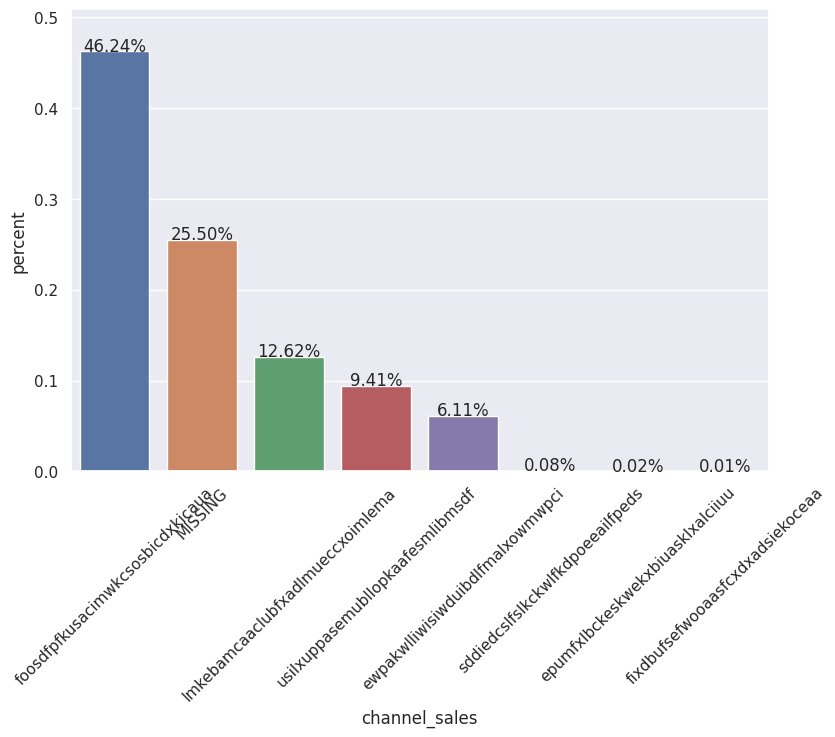

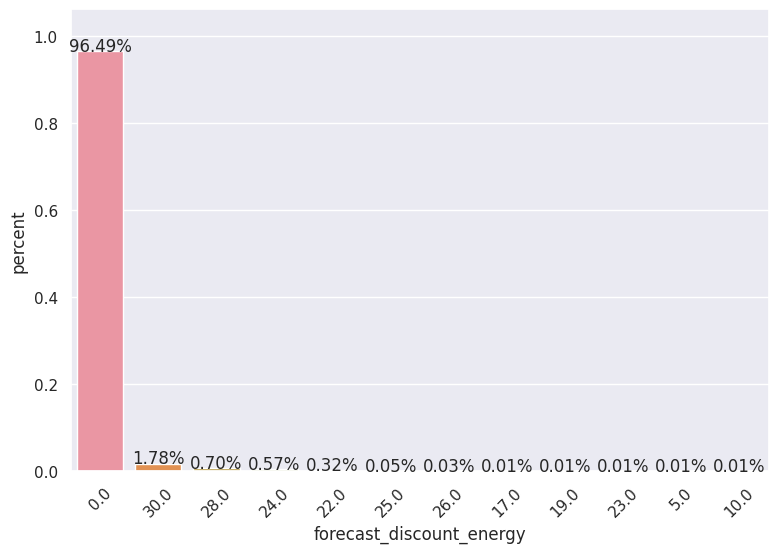

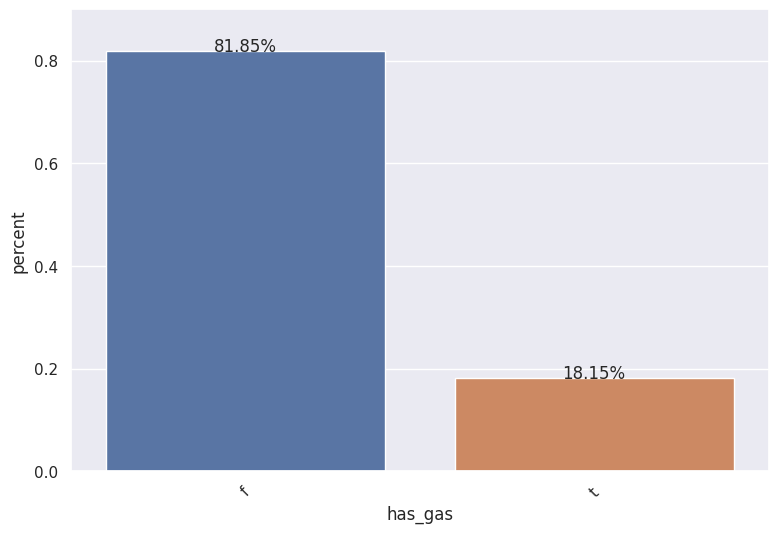

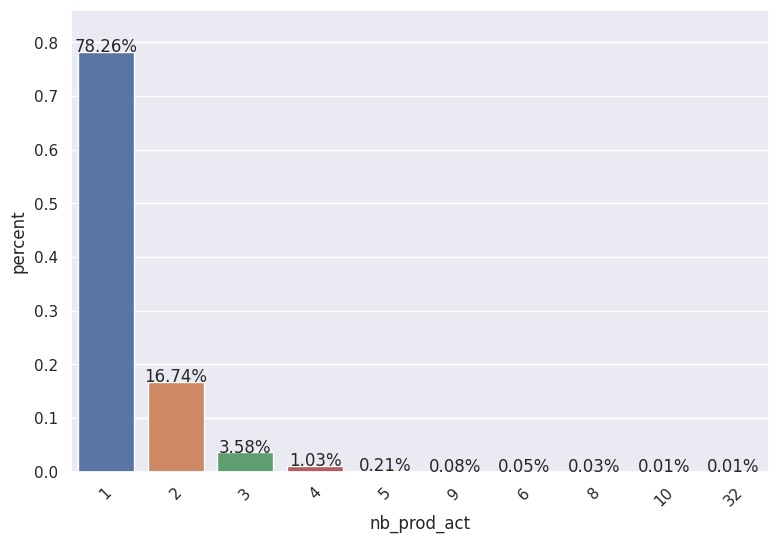

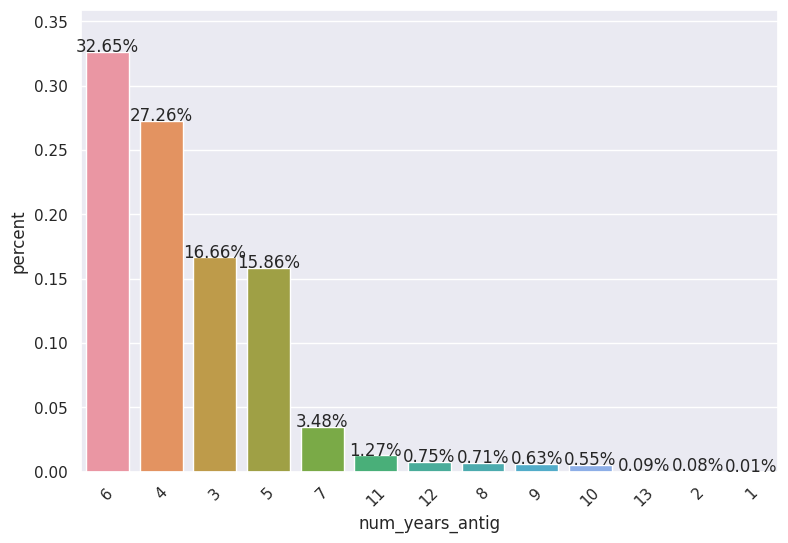

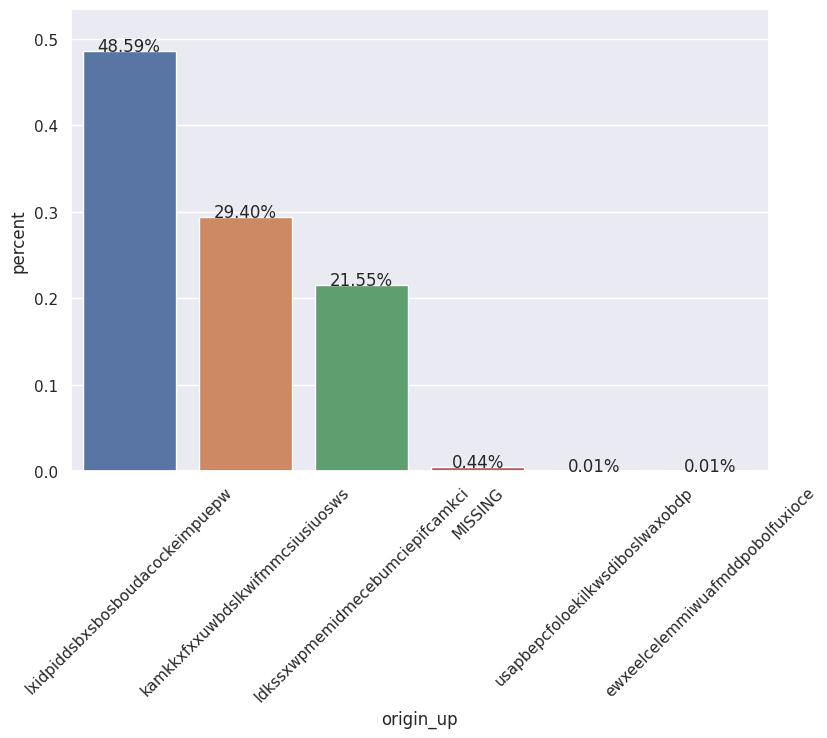

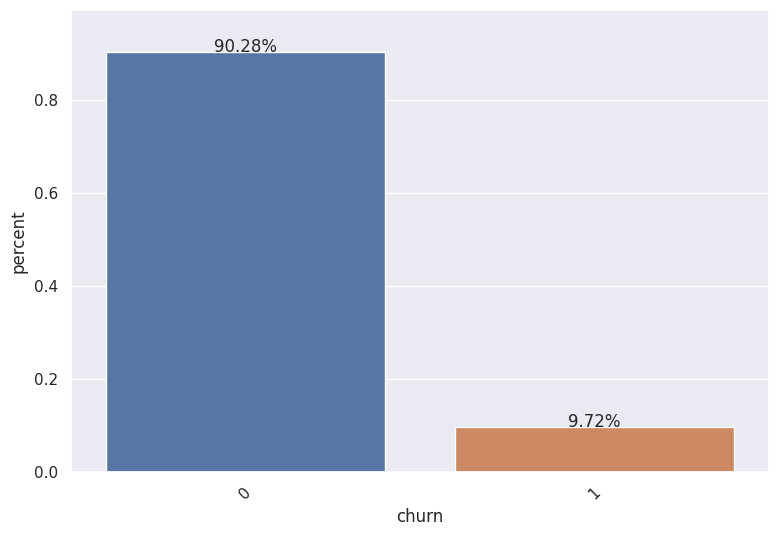

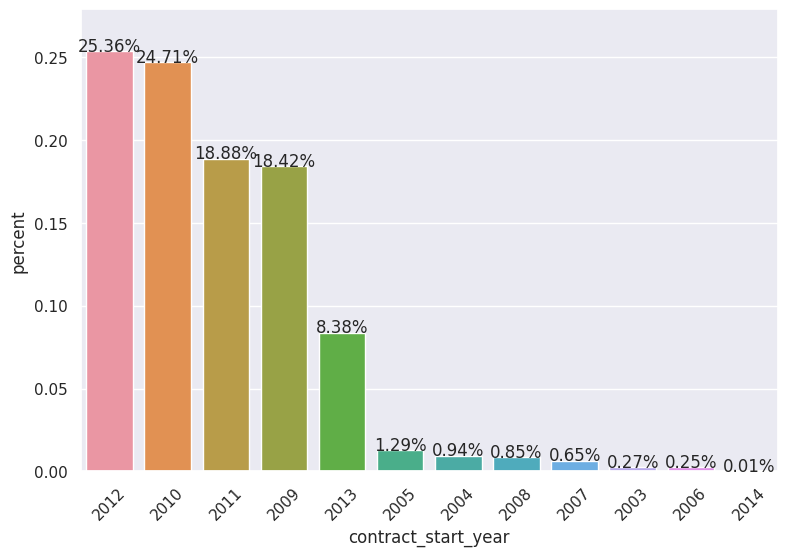

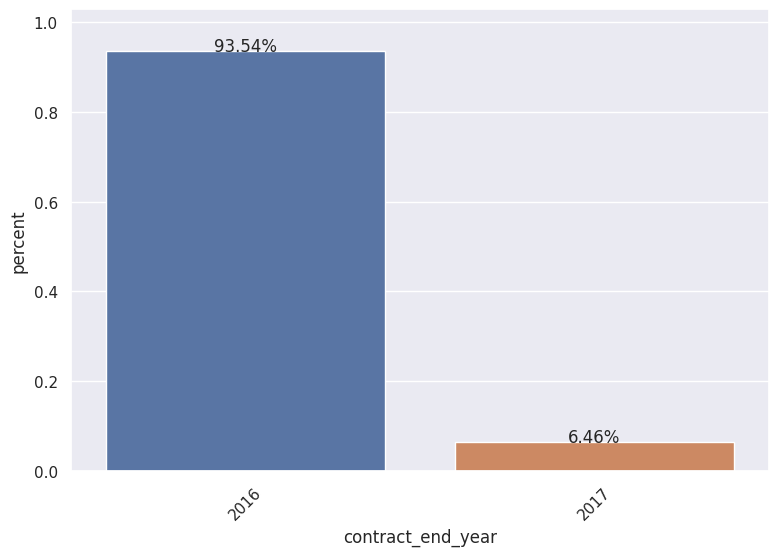

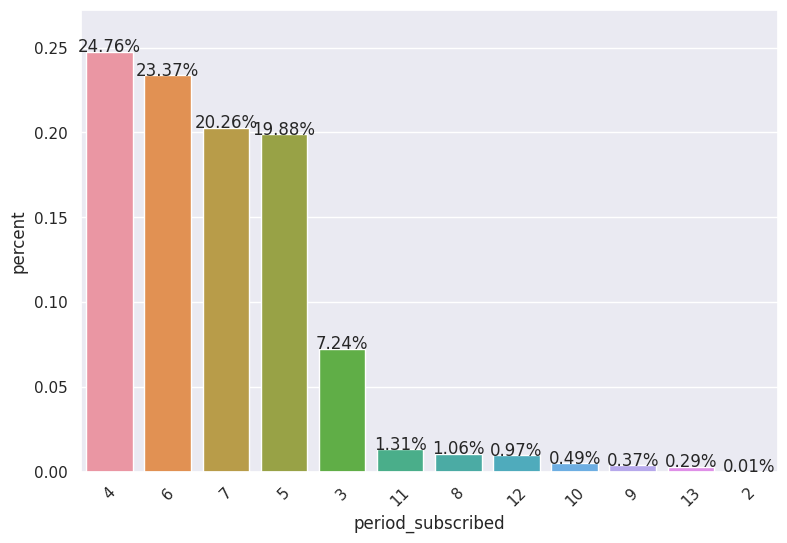

In [25]:
for key, value in discrete_features.items():
    plot_bar_chart_with_percent_label(df=client, target_variable = key, if_sort=True)

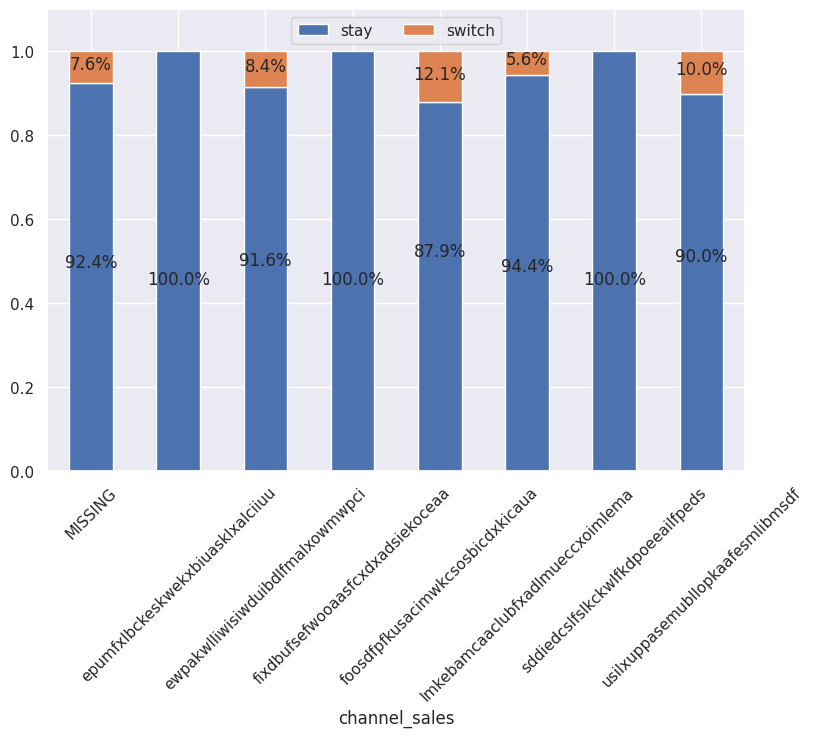

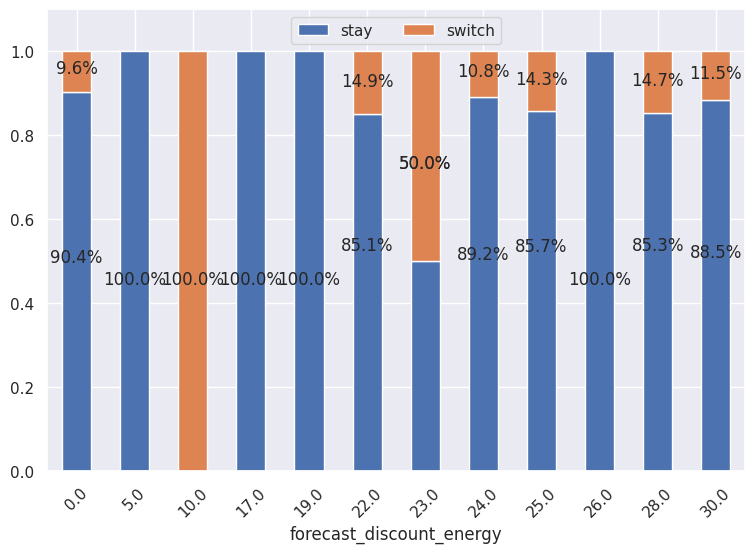

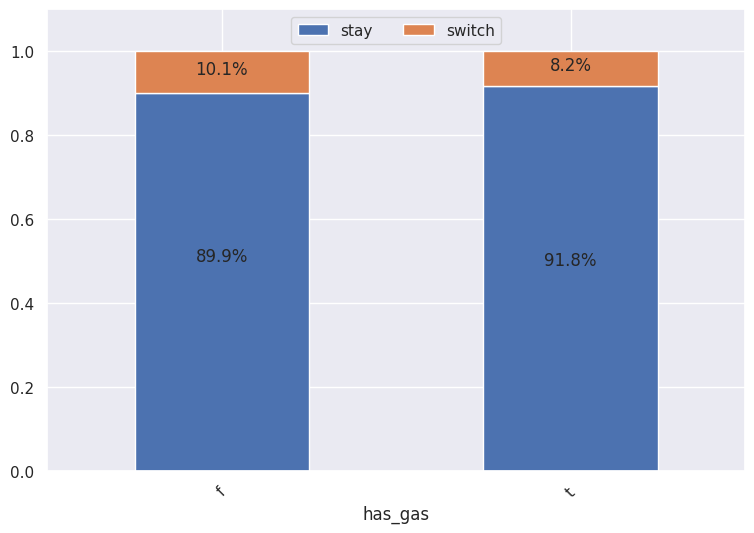

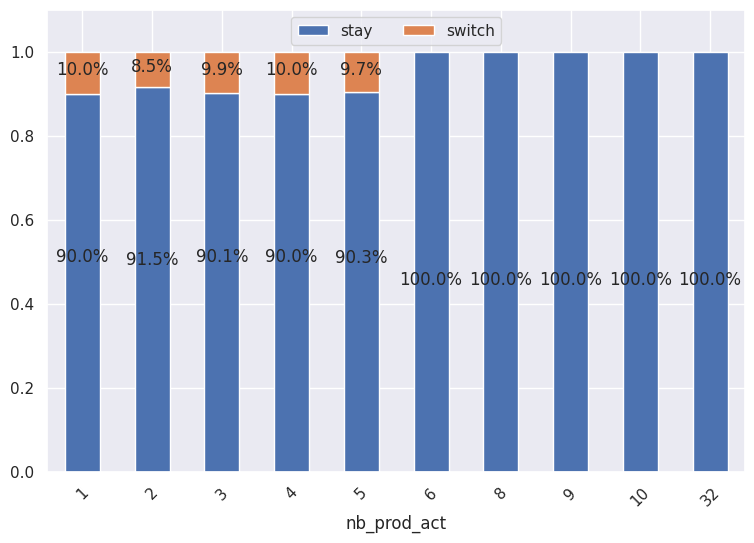

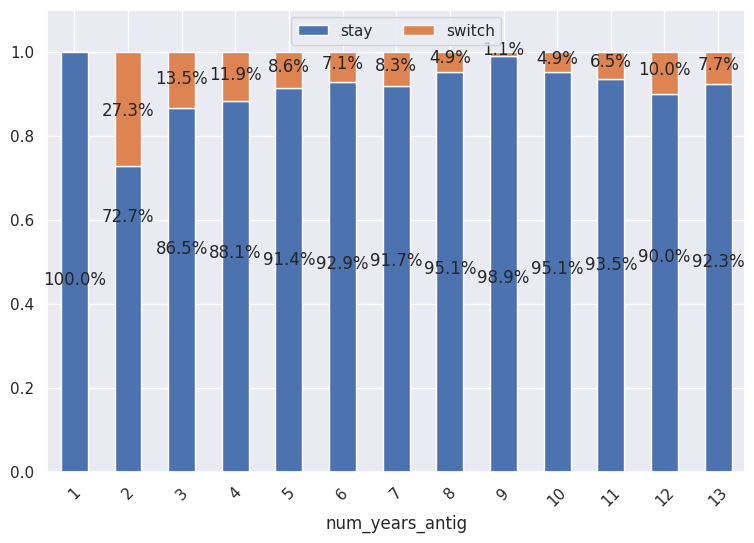

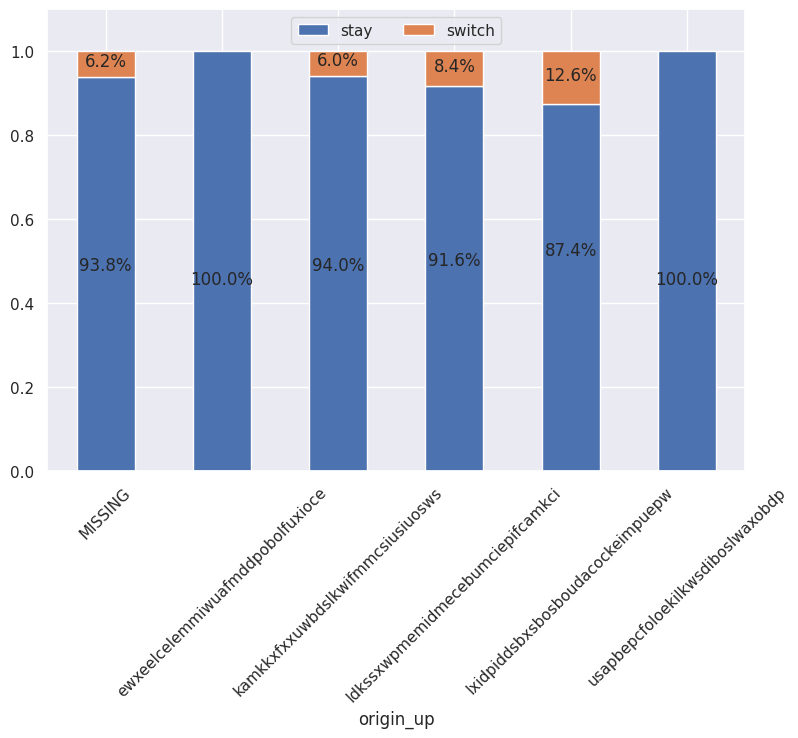

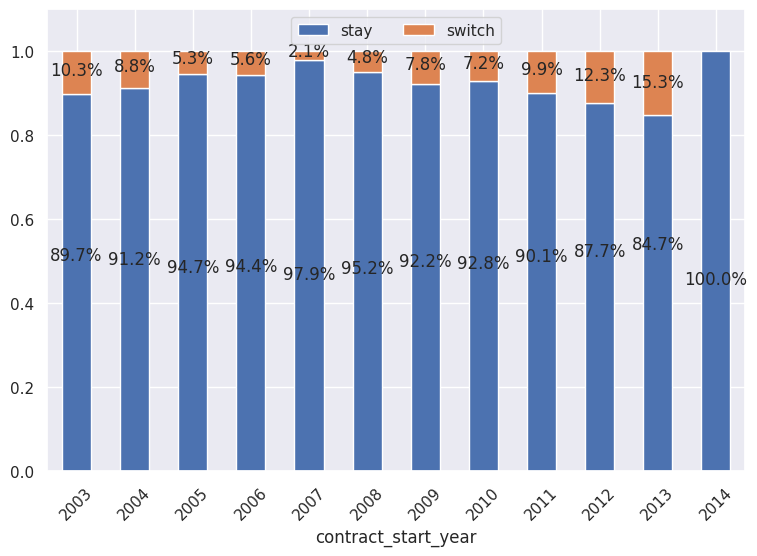

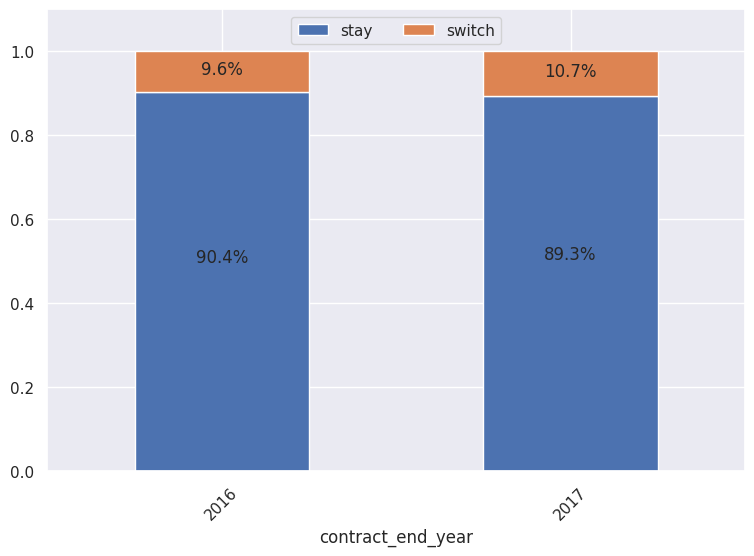

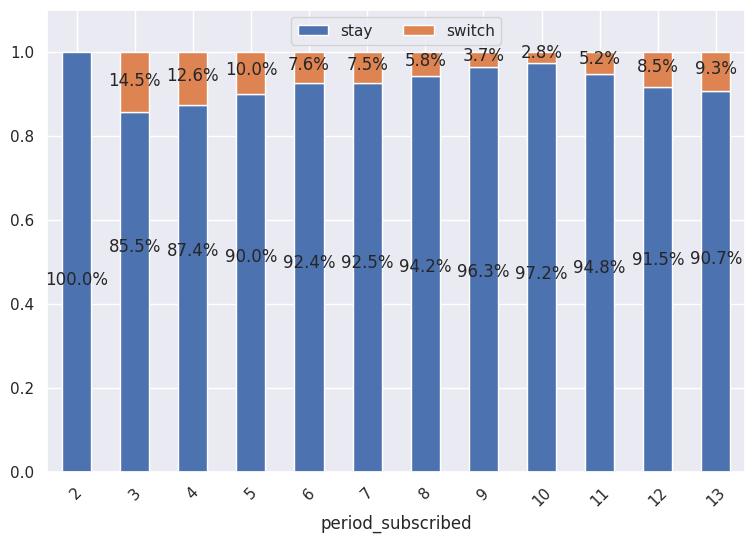

In [26]:
for key, value in discrete_features.items():
    plot_stacked_bar_with_percent_label_by_churn(df=client, target_variable=key, if_sort=False, figsize=(9,6))

In [27]:
#sns.pairplot(price);

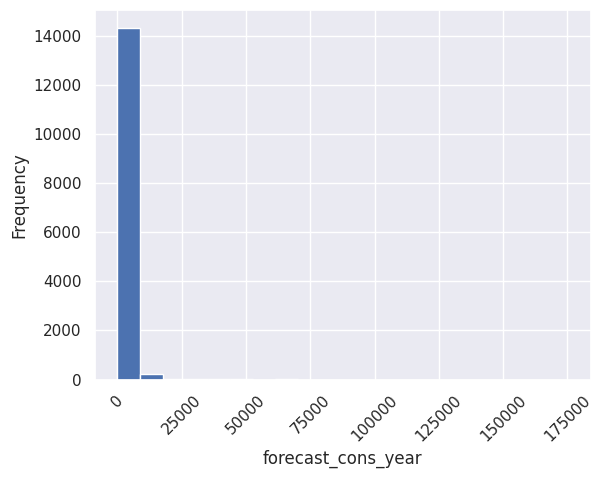

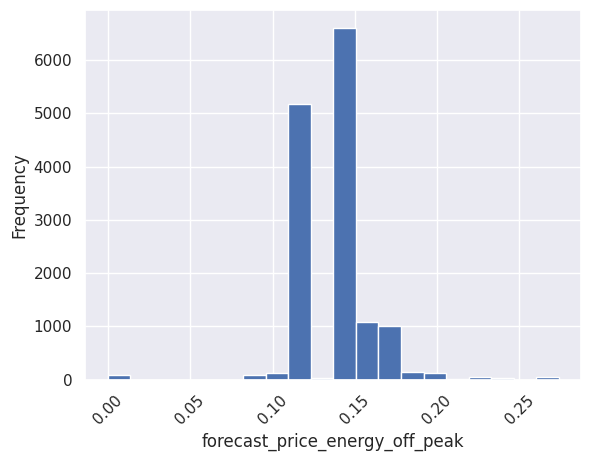

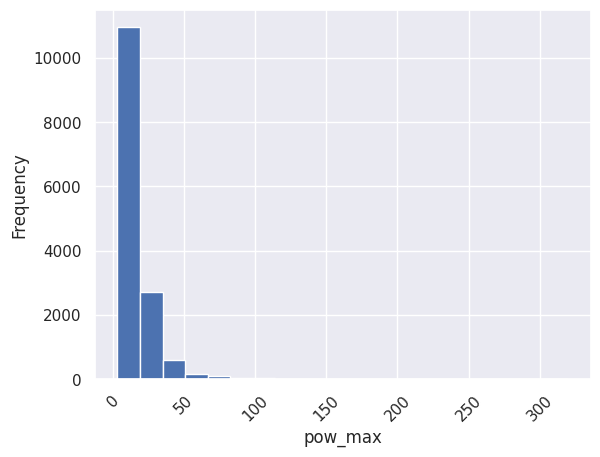

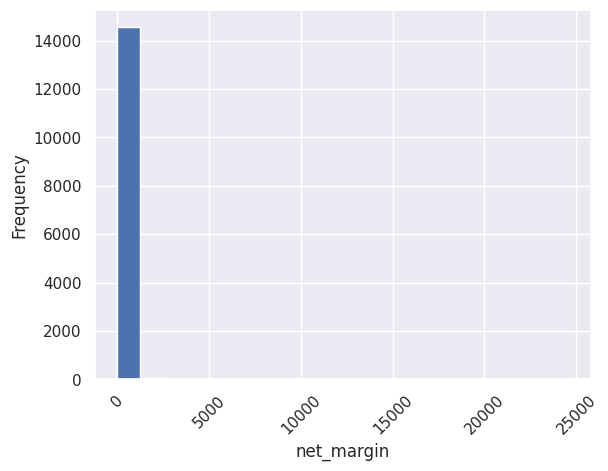

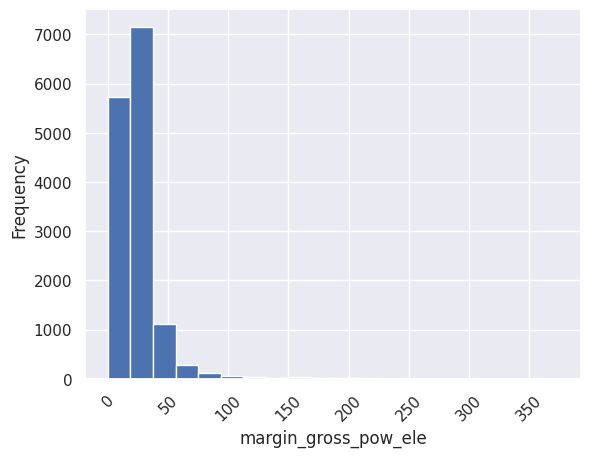

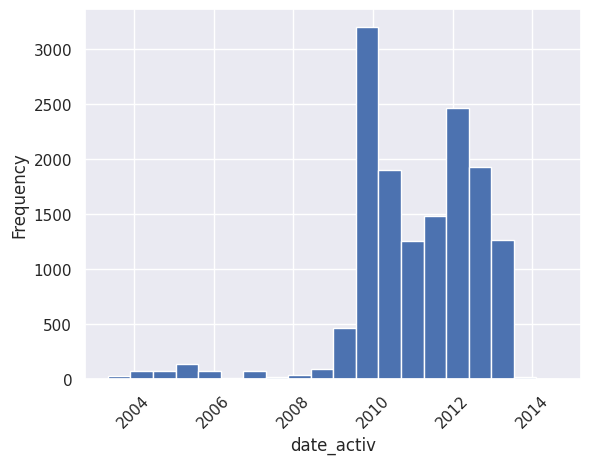

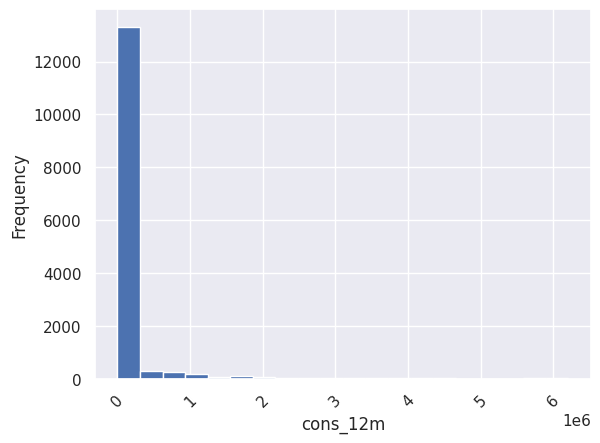

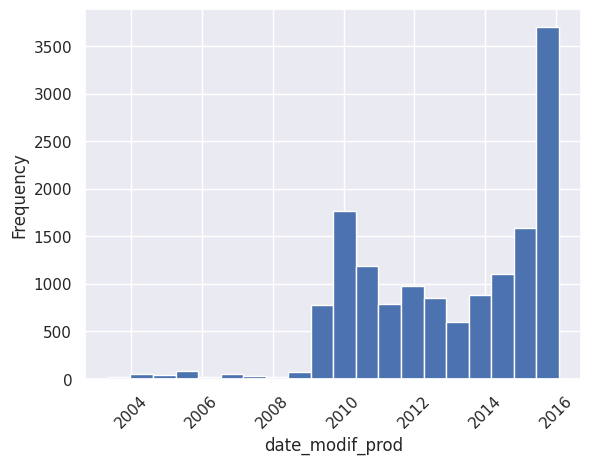

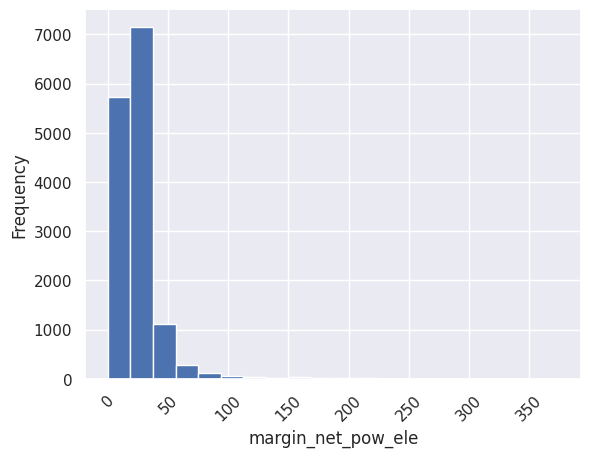

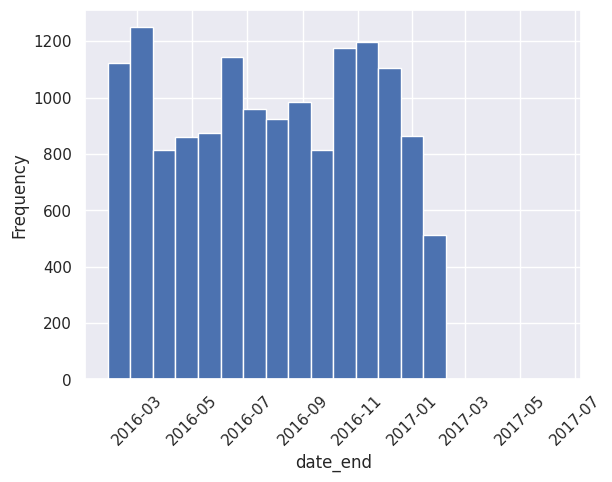

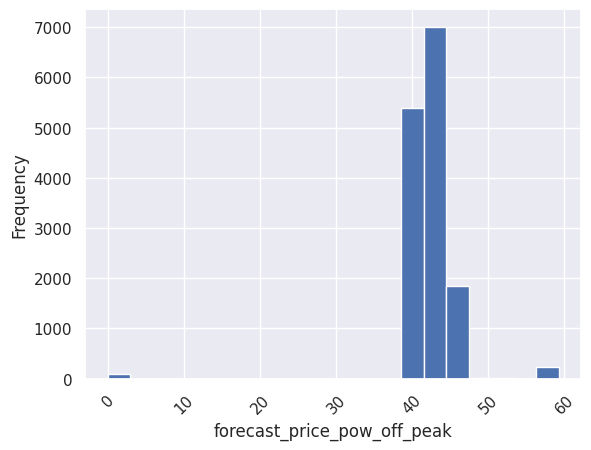

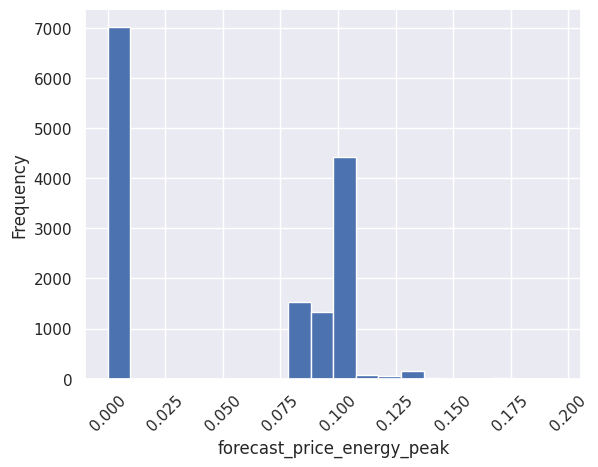

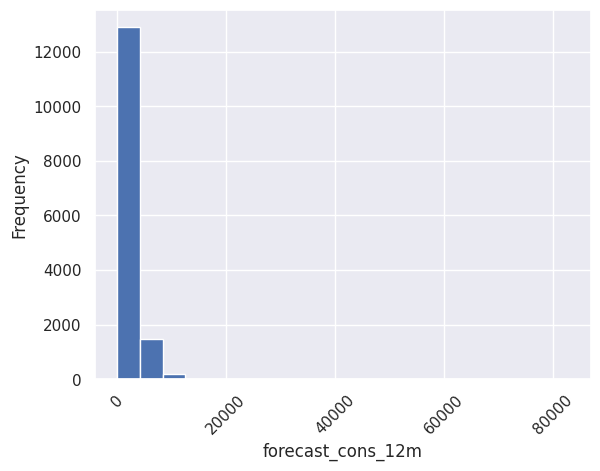

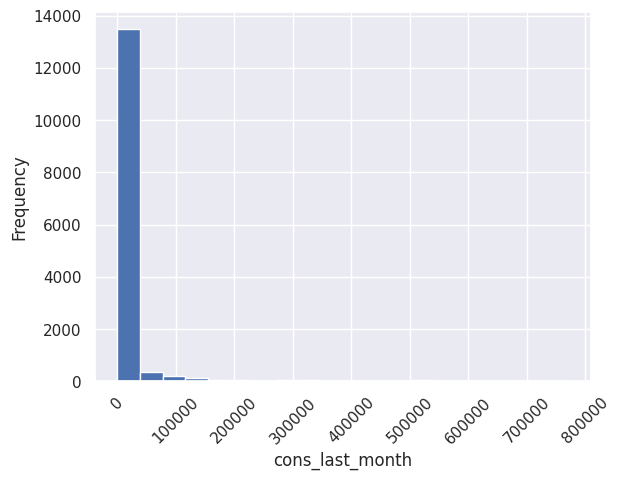

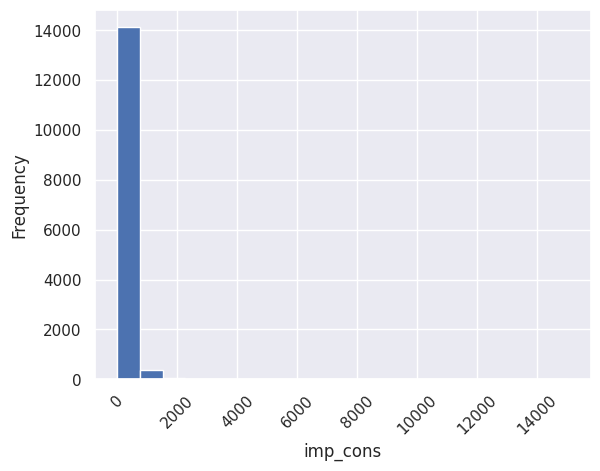

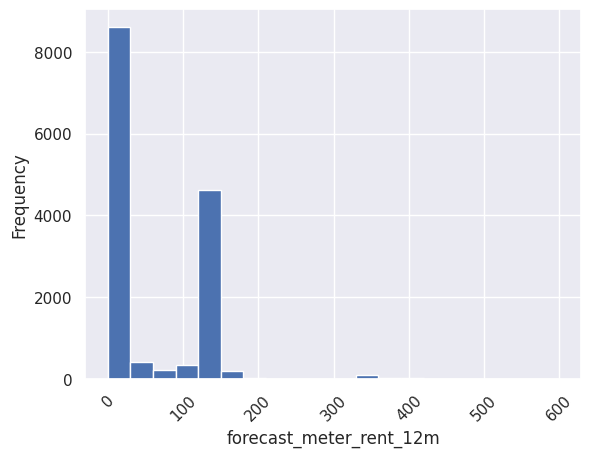

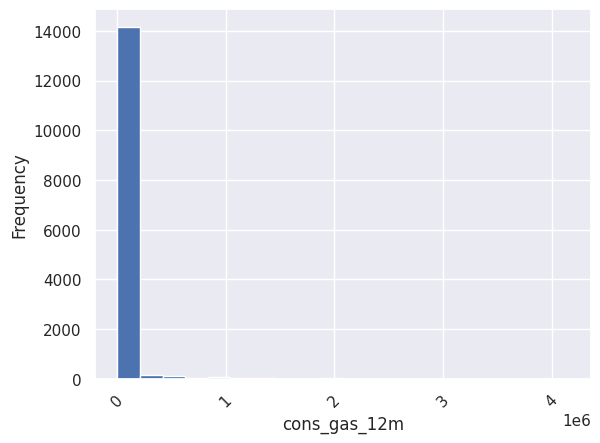

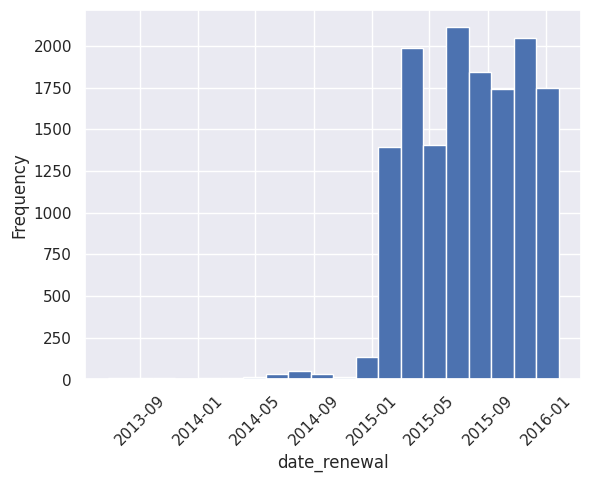

['forecast_cons_year',
 'forecast_price_energy_off_peak',
 'pow_max',
 'net_margin',
 'margin_gross_pow_ele',
 'date_activ',
 'cons_12m',
 'date_modif_prod',
 'margin_net_pow_ele',
 'date_end',
 'forecast_price_pow_off_peak',
 'forecast_price_energy_peak',
 'forecast_cons_12m',
 'cons_last_month',
 'imp_cons',
 'forecast_meter_rent_12m',
 'cons_gas_12m',
 'date_renewal']

In [28]:
# create bins for the variable of interest
variable_of_interest = list(set(client.columns)-set(discrete_features) - {'id'})
num_bins = 20

for i in variable_of_interest:
        
    # plot the frequency histogram
    fig, ax = plt.subplots()
    ax.hist(client[i], bins=20)
    ax.set_xlabel(i)
    ax.set_ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()
variable_of_interest

### **Observations and further questions:**

#### **client.csv dataset**
1. There is some inconsistency in the distributions between the new feature created, **period_subscribed** and the dataset feature **num_years_antig**. I need additional information about num_years_antig to analyze this inconsistency, esp about what it represent.

2. The contracts **(contract_end_year) end mostly in 2016** and some in 2017. Was the scope of this analysis limited to pre-2018 consumption?

3. There's a **sudden rise in subscriptions after 2009**, although the increase wasnt consistent. 95% of all subscriptions took place after 2009.

4. **2, 3, & 4 (encoded) electricity campaigns** were the most effective for consumers.

5. **25% of channel_sales** has the value 'MISSING'. Need further information on whether this implies whether these were legacy customers or if data is not collected. Either way, we'll encode this using LabelEncoder() to preserve this information.

6. Nearly 78% have subscribed to 1 product and around 16% subscribed to 2 products (nb_prod_act).

7. Nearly 10% customers have churned in the period considered for this study.

8. Theres a **near consistent churn** among clients who have subscribed to 5 products or lesser and **zero churn** among those subscribed to more than 5.

9. Something happens after 9th year of being subscribed. Theres a decreasing trend of churn as customer age with PowerCo increases, but beyond 9 years, churn increases with age. Possible dissatisfaction / introduction of better products from suppliers other than PowerCo?

#### **price.csv dataset**

1. The variable description in the price.csv dataset uses the words 'energy' and 'power' for fix and var price features. Need clarity on whether this is mean to be used interchangeably or does this mean im supposed to engineer an new feature based on the relation between energy and power remains to be seen.

2. There seems to be something funny going on between fixed and var price features, despite the ambiguity in nomenclature. These relationships are worth exploring, because of some linear trends.

3. The price features with values as zero: Some sort of ambiguity in what these values represent. Were these clients provided free-service? Or were they simply missing/not-applicable observations? Need clarity from PowerCo.

4. 

In [29]:
## label encoding
channel_encoder = LabelEncoder()
client['channel_sales'] = channel_encoder.fit_transform(client['channel_sales'])
origin_encoder = LabelEncoder()
client['origin_up'] = origin_encoder.fit_transform(client['origin_up'])
has_gas_encoder = LabelEncoder()
client['has_gas'] = has_gas_encoder.fit_transform(client['has_gas']) #t=1, f=2

## test

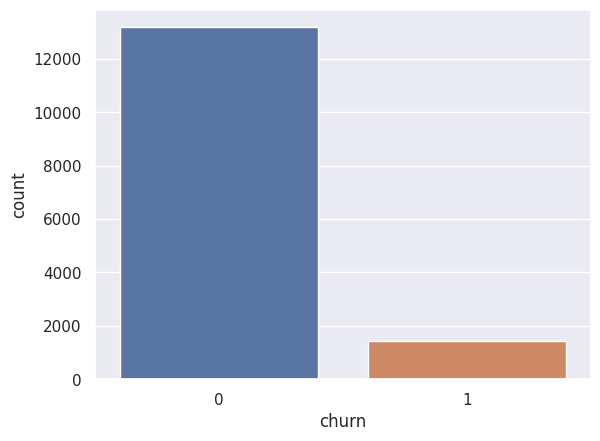

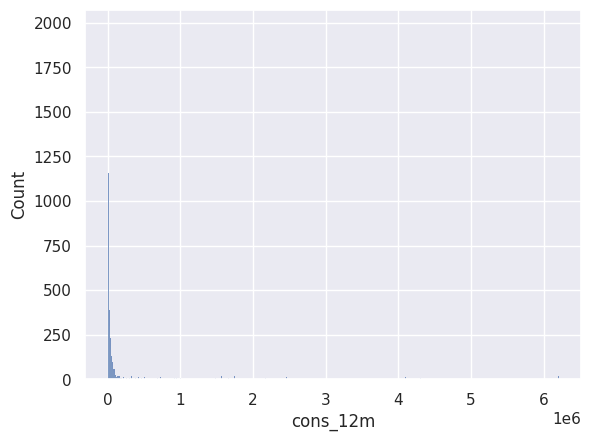

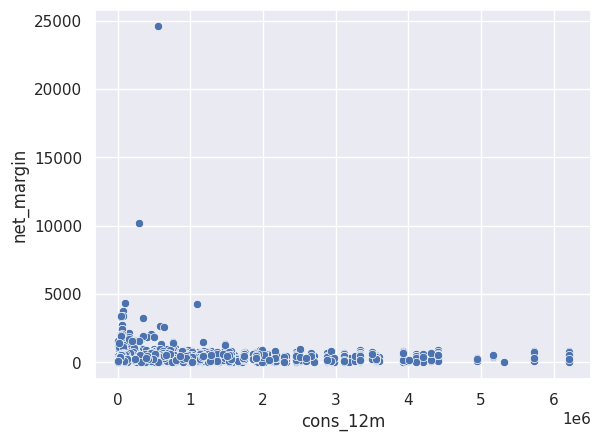

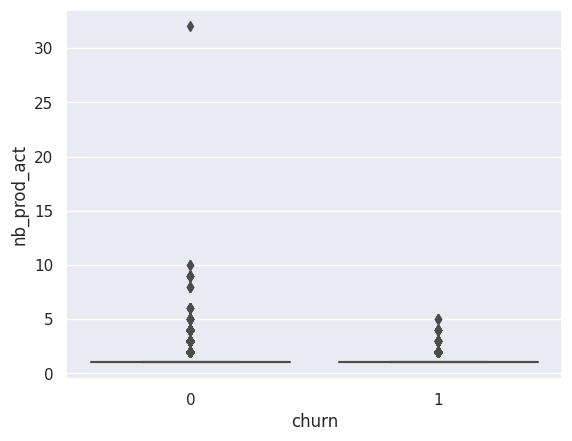

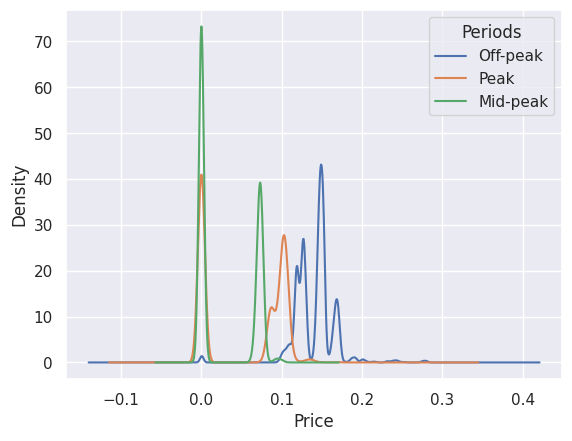

In [30]:
# Load the client_data.csv file
client_df = pd.read_csv('/kaggle/input/bcg-intership-files/client_data.csv')

# Load the price_data.csv file
price_df = pd.read_csv('/kaggle/input/bcg-intership-files/price_data.csv')


# Visualize the target variable (churn) in the client data
sns.countplot(x='churn', data=client_df)
plt.show()

# Visualize the distribution of electricity consumption in the past 12 months
sns.histplot(x='cons_12m', data=client_df)
plt.show()

# Visualize the relationship between net margin and electricity consumption
sns.scatterplot(x='cons_12m', y='net_margin', data=client_df)
plt.show()

# Visualize the relationship between churn and number of active products and services
sns.boxplot(x='churn', y='nb_prod_act', data=client_df)
plt.show()

# Visualize the distribution of energy prices for different periods
price_variable = ['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var']
price_df[price_variable].plot(kind='kde')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend(title='Periods', labels=['Off-peak', 'Peak', 'Mid-peak'])
plt.show()


## test 2


# Load the client_data.csv file
client_data = pd.read_csv('/kaggle/input/bcg-intership-files/client_data.csv')

# Load the price_data.csv file
price_data = pd.read_csv('/kaggle/input/bcg-intership-files/price_data.csv')

# Merge the two datasets on the 'id' column
merged_data = pd.merge(client_data, price_data, on='id', how='inner')

# Select relevant columns
relevant_columns = ['id', 'has_gas', 'cons_last_month', 'forecast_cons_12m',
                    'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m',
                    'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
                    'forecast_price_pow_off_peak', 'num_years_antig',
                    'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var',
                    'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix', 'churn']
data = merged_data[relevant_columns]

# Convert categorical variable 'has_gas' to binary
data['has_gas'] = data['has_gas'].map({'f': 0, 't': 1})

# Define a function to calculate the price elasticity of demand (PED) for each customer
def calculate_ped(row, reference_price):
    # Calculate the current price and demand
    current_price = row[['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var']].sum() + \
    row[['price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']].sum()
    
    current_demand = row['forecast_cons_12m']
    # Calculate the new price and demand after a price change
    new_price = reference_price
    new_demand = row['forecast_cons_12m'] * (1 - row['forecast_price_energy_off_peak'] * (new_price - current_price) / current_price)
    # Calculate the price elasticity of demand
    ped = (new_demand - current_demand) / current_demand / (new_price - current_price) * current_price / current_demand
    return ped

# Define a function to calculate the price sensitivity of churn for a given reference price
def calculate_sensitivity(reference_price):
    # Calculate the PED for each customer
    data['ped'] = data.apply(lambda row: calculate_ped(row, reference_price), axis=1)
    # Calculate the average PED and churn rate for each PED bin
    ped_bins = pd.cut(data['ped'], bins=[-np.inf, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, np.inf], include_lowest=True)
    ped_bins_data = data.groupby(ped_bins).agg({'ped': 'mean', 'churn': 'mean', 'id': 'count'})
    # Plot the sensitivity curve
    plt.plot(ped_bins_data['ped'], ped_bins_data['churn'], label=f"Price = {reference_price}")
    plt.xlabel("Price Elasticity of Demand")
    plt.ylabel("Churn Rate")
    plt.legend()

# Calculate the sensitivity curve for different reference prices
reference_prices = [100, 80, 60, 40, 20]
for i in reference_prices:
    calculate_sensitivity(i)

plt.show()


### Statistics

Now let's look at some statistics about the datasets. We can do this by using the `describe()` method.

---

## Data visualization

If you're working in Python, two of the most popular packages for visualization are `matplotlib` and `seaborn`. We highly recommend you use these, or at least be familiar with them because they are ubiquitous!

Below are some functions that you can use to get started with visualizations. 

In [31]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(kind="bar",stacked=True,figsize=size_,rot=rot_,title=title_)

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

Thhe first function `plot_stacked_bars` is used to plot a stacked bar chart. An example of how you could use this is shown below:

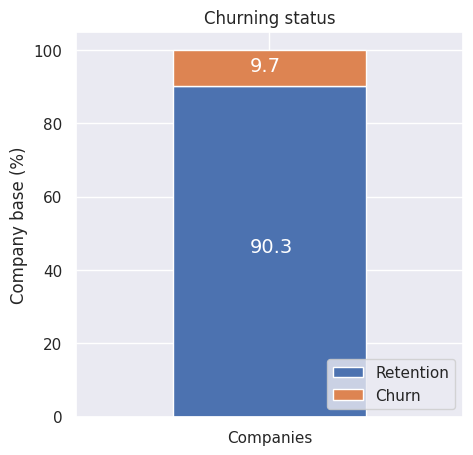

In [32]:
churn = client[['id', 'churn']]
churn.columns = ['Companies', 'churn']
churn_total = churn.groupby(churn['churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100
plot_stacked_bars(churn_percentage.transpose(), "Churning status", (5, 5), legend_="lower right")

The second function `annotate_bars` is used by the first function, but the third function `plot_distribution` helps you to plot the distribution of a numeric column. An example of how it can be used is given below:

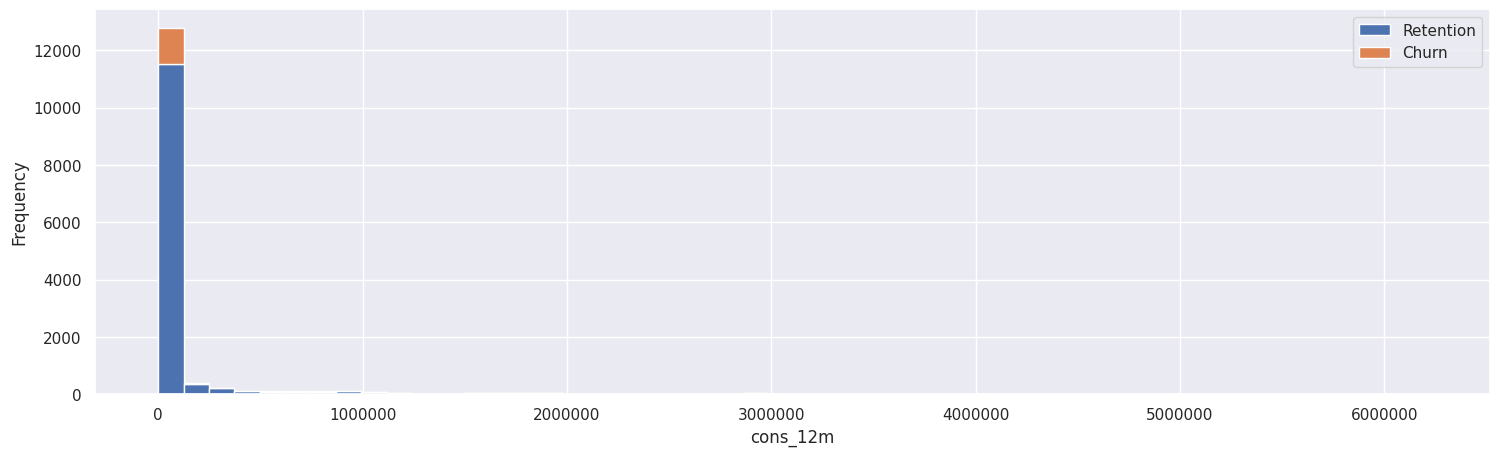

In [33]:
consumption = client[['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons', 'has_gas', 'churn']]

fig, axs = plt.subplots(nrows=1, figsize=(18, 5))

plot_distribution(consumption, 'cons_12m', axs)